# Notebook Overview
1. First, import the training set
2. Then, assign labels for prediction
3. Perform feature selection algorithm
4. Tune hyperparameters for the feature subset

# Step 1: Importing the training set and label assignment

In [1]:
import pandas as pd
import numpy as np
import os

# Define the path to your directory
path = 'C:/Users/Home PC/Documents/P5/ProjectCode/Expanded_Experiment/Files/'
os.chdir(path)

training_df = pd.read_excel('Training/training_dataset_P5.xlsx', 'Sheet1')

print('training data loaded successfully!')

training data loaded successfully!


# Step 2: assign labels for prediction and visualize distribution 
Visualize the distribution of visual sightlines between living to kitchen

LIV_KIT_bin
0_insufficient    105
2_preferred        80
1_sufficient       71
Name: count, dtype: int64


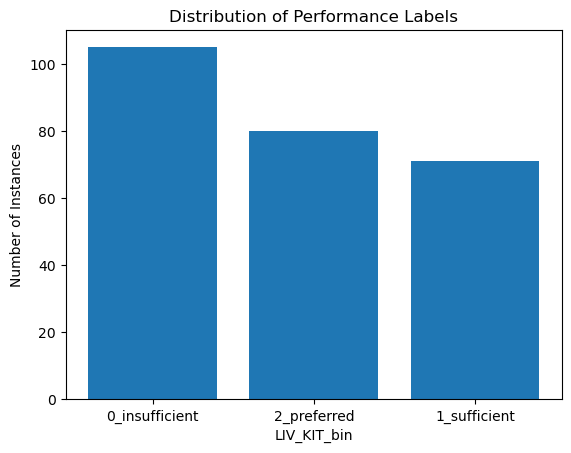

Number of unique 'unit_id' values: 256
apartment_id                             object
site_id                                   int64
building_id                               int64
plan_id                                   int64
floor_id                                  int64
                                         ...   
connectivity_kitchen_distance_p20       float64
connectivity_kitchen_distance_p80       float64
connectivity_kitchen_distance_stddev    float64
layout_biggest_rectangle_length         float64
layout_biggest_rectangle_width          float64
Length: 71, dtype: object


In [2]:
import matplotlib.pyplot as plt

# Get the counts of each category
value_counts = training_df['LIV_KIT_bin'].value_counts()
print(training_df['LIV_KIT_bin'].value_counts())

# Create a bar plot
plt.bar(value_counts.index, value_counts.values)
plt.xlabel('LIV_KIT_bin')
plt.ylabel('Number of Instances')
plt.title('Distribution of Performance Labels')
plt.show()
# Check the number of unique 'unit_id' values in the training_set DataFrame
unique_unit_ids = training_df['unit_id'].nunique()
print("Number of unique 'unit_id' values:", unique_unit_ids)
print(training_df.dtypes)


Assign the labels for living to bathroom sightlines. <br>
In this instance, at least one bathroom should be visible to receive a positive label 'sufficient'

LIV_BATH_bin
0_insufficient    137
1_sufficient      119
Name: count, dtype: int64


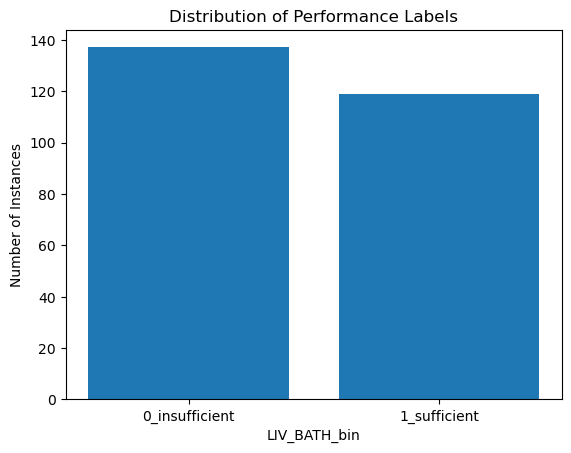

Number of unique 'unit_id' values: 256
Index(['apartment_id', 'site_id', 'building_id', 'plan_id', 'floor_id',
       'unit_id', 'area_id', 'unit_usage', 'entity_type', 'entity_subtype',
       'geometry', 'elevation', 'height', 'LIV_KIT', 'LIV_BED1', 'LIV_BED2',
       'LIV_BED3', 'LIV_BED4', 'LIV_BED5', 'LIV_BED6', '# OF BEDS',
       'LIV_BATH1', 'LIV_BATH2', 'LIV_BATH3', '# OF BATH', 'invalid_geometry',
       'LIV_KIT_bin', 'LIV_KIT_bin_mapped', 'layout_compactness',
       'layout_std_walllengths', 'layout_perimeter', 'layout_door_perimeter',
       'layout_open_perimeter', 'layout_number_of_doors',
       'connectivity_entrance_door_distance_max',
       'connectivity_entrance_door_distance_mean',
       'connectivity_entrance_door_distance_median',
       'connectivity_entrance_door_distance_min',
       'connectivity_entrance_door_distance_p20',
       'connectivity_entrance_door_distance_p80',
       'connectivity_entrance_door_distance_stddev',
       'connectivity_betweenne

In [3]:
# Add sightlines from living to toilet label with two possible classes: insufficient and sufficient
training_df['LIV_BATH_bin'] = training_df[['LIV_BATH1', 'LIV_BATH2']].max(axis=1).apply(lambda x: '0_insufficient' if x == 0 else '1_sufficient').astype(str)

# Get the counts of each category
value_counts = training_df['LIV_BATH_bin'].value_counts()
print(training_df['LIV_BATH_bin'].value_counts())

# Create a bar plot
plt.bar(value_counts.index, value_counts.values)
plt.xlabel('LIV_BATH_bin')
plt.ylabel('Number of Instances')
plt.title('Distribution of Performance Labels')
plt.show()
# Check the number of unique 'unit_id' values in the training_set DataFrame
unique_unit_ids = training_df['unit_id'].nunique()
print("Number of unique 'unit_id' values:", unique_unit_ids)
print(training_df.columns)

# Bath Bin Mapping

# Define a mapping dictionary
bin_mapping = {'0_insufficient': 0, '1_sufficient': 1}

# Map the values and create a new column
training_df['LIV_BATH_bin_mapped'] = training_df['LIV_BATH_bin'].map(bin_mapping)

pd.set_option('display.max_columns', None)  # Display all columns
print(training_df.dtypes)



Assign living to bedroom sightlines. <br>
In this instance, we take into consideration how many bedrooms are in a household, how many of them are visible from any single point in the living room. Then, we divide the number of visible bedrooms by the total bedrooms in the household to get a ratio for the visual connection between living to bedroom. <br>
<br>
1. A visibility ratio of above 0.50 of bedrooms is sufficient <br>
2. A visibility ratio of less than 0.50 is sufficient<br>
3. A visibility ratio of less than 0.25 is insufficient <br>

     LIV_BED_count  LIV_BED_ratio     LIV_BED_bin
0                1       0.333333    1_sufficient
1                0       0.000000  0_insufficient
2                0       0.000000  0_insufficient
3                2       0.500000    1_sufficient
4                0       0.000000  0_insufficient
..             ...            ...             ...
251              2       0.500000    1_sufficient
252              2       0.666667     2_preferred
253              0       0.000000  0_insufficient
254              1       0.500000    1_sufficient
255              0       0.000000  0_insufficient

[256 rows x 3 columns]
LIV_BED_bin
0_insufficient    118
2_preferred        72
1_sufficient       66
Name: count, dtype: int64


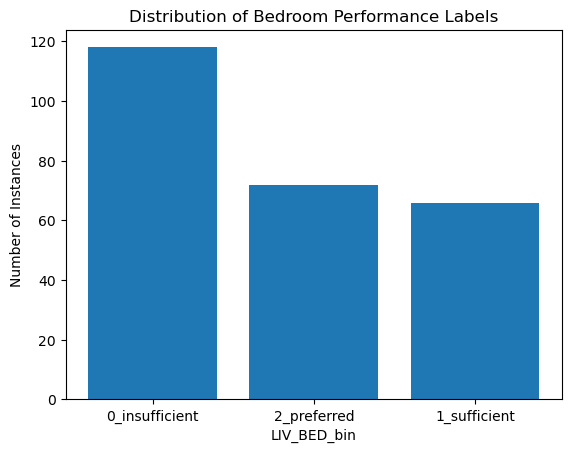

In [4]:
# Calculate the number of bedrooms with sightline greater than 0
training_df['LIV_BED_count'] = training_df[['LIV_BED1', 'LIV_BED2', 'LIV_BED3', 'LIV_BED4', 'LIV_BED5', 'LIV_BED6']].apply(lambda row: (row > 0).sum(), axis=1)
# Calculate the ratio
training_df['LIV_BED_ratio'] = training_df['LIV_BED_count'] / training_df['# OF BEDS']

# Create the LIV_BED_bin column based on the ratio
def classify_bed_ratio(ratio):
    if ratio > 0.5:
        return '2_preferred'
    elif ratio > 0.25:
        return '1_sufficient'
    else:
        return '0_insufficient'

training_df['LIV_BED_bin'] = training_df['LIV_BED_ratio'].apply(classify_bed_ratio)

# Print the resulting DataFrame
print(training_df[['LIV_BED_count', 'LIV_BED_ratio', 'LIV_BED_bin']])

# Get the counts of each category
value_counts = training_df['LIV_BED_bin'].value_counts()
print(training_df['LIV_BED_bin'].value_counts())

# Create a bar plot
plt.bar(value_counts.index, value_counts.values)
plt.xlabel('LIV_BED_bin')
plt.ylabel('Number of Instances')
plt.title('Distribution of Bedroom Performance Labels')
plt.show()

# Feature selection

First identify all the possible features relevant for the model<br>
Assign a number to each feature to call out the ones relevant based on their index value

In [5]:
# Create a DataFrame with column indices and names
index_names_df = pd.DataFrame({'Index': range(len(training_df.columns)), 'Column Name': training_df.columns})

# Convert DataFrame to a list of tuples (index, column name)
index_names_list = list(index_names_df.to_records(index=False))

# Print the list of tuples
print("List of column indices and names:")
print(index_names_list)



List of column indices and names:
[(0, 'apartment_id'), (1, 'site_id'), (2, 'building_id'), (3, 'plan_id'), (4, 'floor_id'), (5, 'unit_id'), (6, 'area_id'), (7, 'unit_usage'), (8, 'entity_type'), (9, 'entity_subtype'), (10, 'geometry'), (11, 'elevation'), (12, 'height'), (13, 'LIV_KIT'), (14, 'LIV_BED1'), (15, 'LIV_BED2'), (16, 'LIV_BED3'), (17, 'LIV_BED4'), (18, 'LIV_BED5'), (19, 'LIV_BED6'), (20, '# OF BEDS'), (21, 'LIV_BATH1'), (22, 'LIV_BATH2'), (23, 'LIV_BATH3'), (24, '# OF BATH'), (25, 'invalid_geometry'), (26, 'LIV_KIT_bin'), (27, 'LIV_KIT_bin_mapped'), (28, 'layout_compactness'), (29, 'layout_std_walllengths'), (30, 'layout_perimeter'), (31, 'layout_door_perimeter'), (32, 'layout_open_perimeter'), (33, 'layout_number_of_doors'), (34, 'connectivity_entrance_door_distance_max'), (35, 'connectivity_entrance_door_distance_mean'), (36, 'connectivity_entrance_door_distance_median'), (37, 'connectivity_entrance_door_distance_min'), (38, 'connectivity_entrance_door_distance_p20'), (39,

Select the feature set, including the target variable for sightline classes

In [6]:
# Add all fitures from simulation file 
column_indices = [[26,27,71,72], # All assessment result classes
                  [28,29,30,31,32,32,33], # Layout compactness
                  [], # Adjacencies and relationships
                  [], # Centrality 
                  [38,39], # Distance to entrance door 
                  [45,46], # Betweeenness
                  [52,53], # Closesness
                  [], # (living?) Room distances
                  [], # Living - Dining distance
                  [59,60], # Bathroom distance
                  [66,67], # Kitchen distance
                  [], # Distance to balcony
                  [69,70]] # Layout biggest rectangle length and width



training_df = training_df.iloc[:, [item for sublist in column_indices for item in sublist]]

# Get column names of Swiss_sim_selected
column_names = list(training_df.columns)
print(column_names)

['LIV_KIT_bin', 'LIV_KIT_bin_mapped', 'LIV_BATH_bin', 'LIV_BATH_bin_mapped', 'layout_compactness', 'layout_std_walllengths', 'layout_perimeter', 'layout_door_perimeter', 'layout_open_perimeter', 'layout_open_perimeter', 'layout_number_of_doors', 'connectivity_entrance_door_distance_p20', 'connectivity_entrance_door_distance_p80', 'connectivity_betweenness_centrality_p20', 'connectivity_betweenness_centrality_p80', 'connectivity_closeness_centrality_p20', 'connectivity_closeness_centrality_p80', 'connectivity_bathroom_distance_p20', 'connectivity_bathroom_distance_p80', 'connectivity_kitchen_distance_p20', 'connectivity_kitchen_distance_p80', 'layout_biggest_rectangle_length', 'layout_biggest_rectangle_width']


In [7]:
# Assign training classes with multiple outputs
X = training_df.drop(columns=[
    'LIV_KIT_bin', 
    'LIV_KIT_bin_mapped', 
    'LIV_BATH_bin', 
    'LIV_BATH_bin_mapped'
    # 'LIV_BED_bin'
])
y = training_df[['LIV_KIT_bin', 'LIV_BATH_bin']] #removed: 'LIV_BED_bin'


print('OK!')


OK!


## Import Libraries

In [8]:
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from tensorflow.keras.models import Sequential
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from tensorflow.keras.layers import Dense, BatchNormalization, Dropout
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam, RMSprop
from sklearn.model_selection import train_test_split
import numpy as np
from scikeras.wrappers import KerasClassifier
import matplotlib.pyplot as plt
from scipy.stats import expon 
from keras.regularizers import l1_l2
from sklearn.model_selection import KFold


test_size = 0.3
random_state = 42  # Fixed random state for reproducibility
cv_folds = 5

# Set up cross-validation with a fixed random seed
cv = KFold(n_splits=cv_folds, shuffle=True, random_state=random_state)


print('OK!')


OK!


In [9]:
from sklearn.metrics import make_scorer, hamming_loss, accuracy_score
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
import numpy as np

# Custom scoring functions
def hamming_loss_score(y_true, y_pred):
    return np.sum(y_true.values != y_pred) / np.size(y_true)

def subset_accuracy_score(y_true, y_pred):
    return np.mean(np.all(y_true == y_pred, axis=1))

hamming_loss_scorer = make_scorer(hamming_loss_score, greater_is_better=False)
subset_accuracy_scorer = make_scorer(subset_accuracy_score, greater_is_better=True)




# Initialize variables to track the best score and features
best_score = 0  # Start with the lowest possible value since we are maximizing subset accuracy
best_features = None
feature_counts = []
hamming_losses = []
subset_accuracies = []

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Input, BatchNormalization, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l1_l2
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from scikeras.wrappers import KerasClassifier

# Split the data into training and testing sets
test_size = 0.3
random_state = 42  # Fixed random state for reproducibility
cv_folds = 5


y1 = OneHotEncoder(sparse_output=False).fit_transform(y['LIV_KIT_bin'].values.reshape(-1, 1))
y2 = OneHotEncoder(sparse_output=False).fit_transform(y['LIV_BATH_bin'].values.reshape(-1, 1))

X_train, X_test, y1_train, y1_test, y2_train, y2_test = train_test_split(X, y1, y2, test_size=test_size, random_state=random_state)

# Encode the target variables
label_encoder_1 = LabelEncoder()
label_encoder_2 = LabelEncoder()

y['LIV_KIT_bin'] = label_encoder_1.fit_transform(y['LIV_KIT_bin'])
y['LIV_BATH_bin'] = label_encoder_2.fit_transform(y['LIV_BATH_bin'])


C:\Users\Home PC\AppData\Local\Temp\ipykernel_14876\3386989443.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y['LIV_KIT_bin'] = label_encoder_1.fit_transform(y['LIV_KIT_bin'])
C:\Users\Home PC\AppData\Local\Temp\ipykernel_14876\3386989443.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y['LIV_BATH_bin'] = label_encoder_2.fit_transform(y['LIV_BATH_bin'])


In [11]:
# Check the shape of y1 and y2 after one-hot encoding
print(f"Shape of y1: {y1.shape}")
print(f"Shape of y2: {y2.shape}")

Shape of y1: (256, 3)
Shape of y2: (256, 2)


Epoch 1/500
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 1.9991 - output_1_accuracy: 0.2487 - output_2_accuracy: 0.5050 - val_loss: 1.7323 - val_output_1_accuracy: 0.5000 - val_output_2_accuracy: 0.6667
Epoch 2/500
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.8662 - output_1_accuracy: 0.4005 - output_2_accuracy: 0.5401 - val_loss: 1.6978 - val_output_1_accuracy: 0.5000 - val_output_2_accuracy: 0.6667
Epoch 3/500
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.7987 - output_1_accuracy: 0.4176 - output_2_accuracy: 0.5484 - val_loss: 1.6859 - val_output_1_accuracy: 0.5000 - val_output_2_accuracy: 0.6667
Epoch 4/500
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.8160 - output_1_accuracy: 0.3872 - output_2_accuracy: 0.4689 - val_loss: 1.6939 - val_output_1_accuracy: 0.5000 - val_output_2_accuracy: 0.6667
Epoch 5/500
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.7711 - output_1_accuracy: 0.4354 - output_2_accuracy: 0.5058 - val_loss: 1.7064 - val_output_1_accuracy: 0.5000 - val_output_2_a

c:\ProgramData\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\ProgramData\anaconda3\Lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


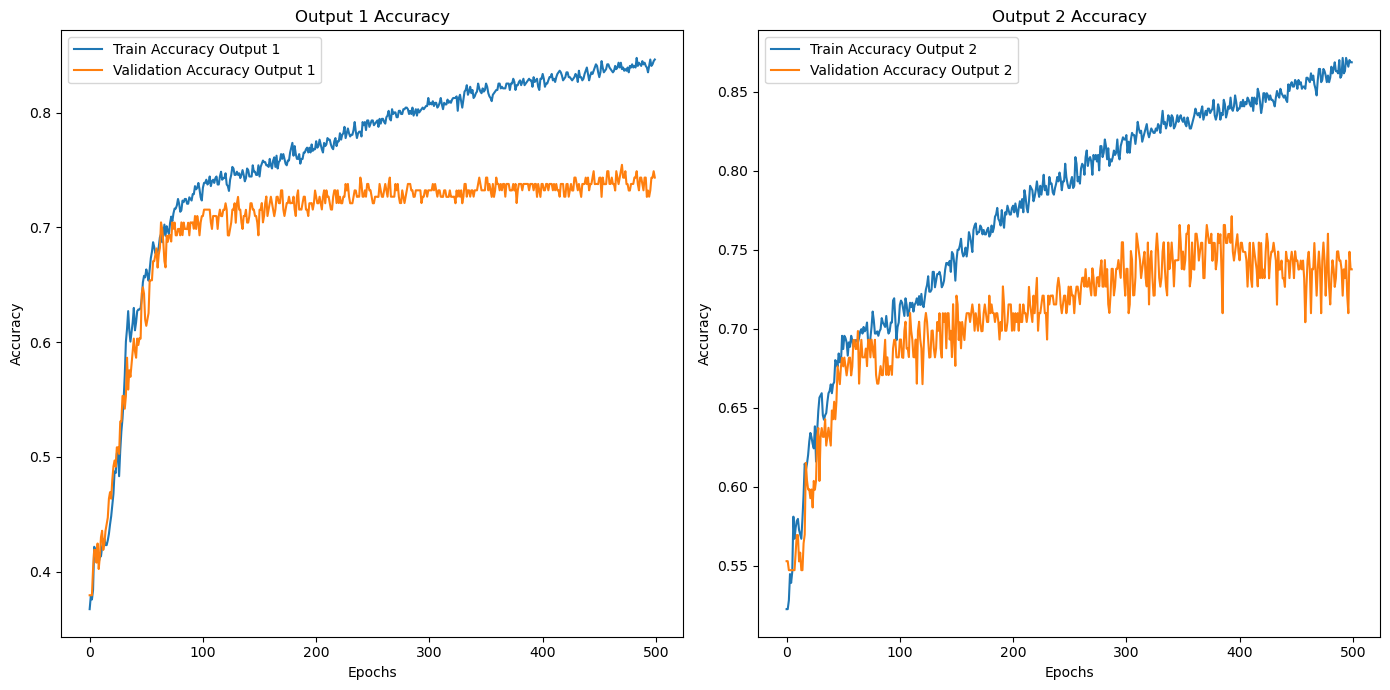

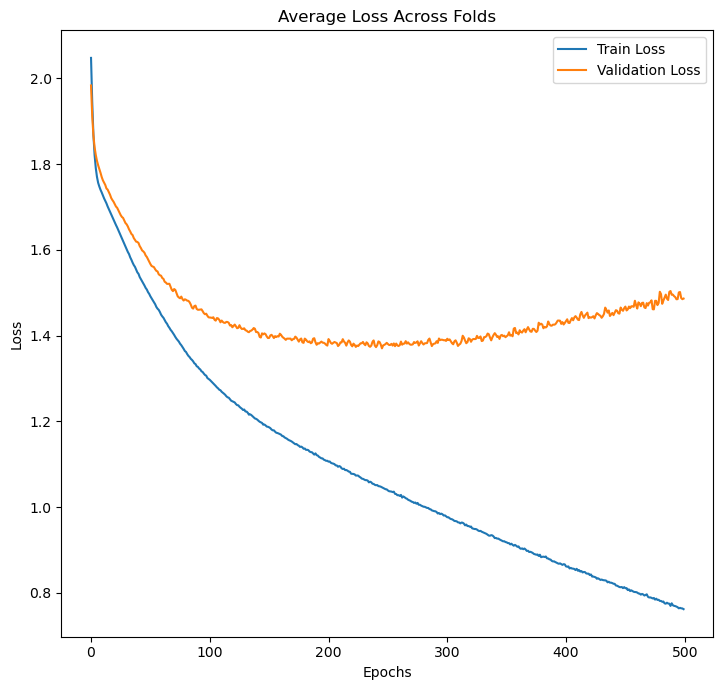

In [12]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l1_l2
from tensorflow.keras.losses import CategoricalCrossentropy

# Define the model parameters
epochs = 500
activation = 'sigmoid'
dropout_rate = 0
l1 = 0
l2 = 0
learning_rate = 0.001
neurons = [32, 32]
num_hidden_layers = 2
cv_folds = 5
random_state = 42  # Ensure random_state is defined

# Create the model using the Functional API
def create_model(input_shape):
    inputs = Input(shape=(input_shape,))
    x = Dense(neurons[0], activation=activation, kernel_regularizer=l1_l2(l1=l1, l2=l2))(inputs)
    x = Dropout(dropout_rate)(x)
    for _ in range(1, num_hidden_layers):
        x = Dense(neurons[1], activation=activation, kernel_regularizer=l1_l2(l1=l1, l2=l2))(x)
        x = Dropout(dropout_rate)(x)
    output_1 = Dense(3, activation='softmax', name='output_1')(x)
    output_2 = Dense(2, activation='softmax', name='output_2')(x)
    model = Model(inputs=inputs, outputs=[output_1, output_2])
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(loss={'output_1': 'categorical_crossentropy', 'output_2': 'categorical_crossentropy'},
                  optimizer=optimizer, 
                  metrics={'output_1': 'accuracy', 'output_2': 'accuracy'})
    return model

# Ensure X_train and y_train are NumPy arrays
X_train = np.array(X_train)
y1_train = np.array(y1_train)
y2_train = np.array(y2_train)

# Set up cross-validation
cv = KFold(n_splits=cv_folds, shuffle=True, random_state=random_state)

# Initialize lists to store the results
all_train_loss_output_1 = []
all_val_loss_output_1 = []
all_train_loss_output_2 = []
all_val_loss_output_2 = []

all_train_acc_output_1 = []
all_val_acc_output_1 = []
all_train_acc_output_2 = []
all_val_acc_output_2 = []

# Cross-validation
for train_idx, val_idx in cv.split(X_train):
    X_cv_train, X_cv_val = X_train[train_idx], X_train[val_idx]
    y1_cv_train, y1_cv_val = y1_train[train_idx], y1_train[val_idx]
    y2_cv_train, y2_cv_val = y2_train[train_idx], y2_train[val_idx]

    # Create a new instance of the model
    model = create_model(X_train.shape[1])

    # Train the model
    history = model.fit(X_cv_train, [y1_cv_train, y2_cv_train], epochs=epochs, batch_size=32, validation_data=(X_cv_val, [y1_cv_val, y2_cv_val]))

    # Append losses for each fold
    all_train_loss_output_1.append(history.history['loss'])
    all_val_loss_output_1.append(history.history['val_loss'])
    
    # Append accuracies for each fold
    all_train_acc_output_1.append(history.history['output_1_accuracy'])
    all_val_acc_output_1.append(history.history['val_output_1_accuracy'])
    all_train_acc_output_2.append(history.history['output_2_accuracy'])
    all_val_acc_output_2.append(history.history['val_output_2_accuracy'])

# Calculate average metrics across all folds
avg_train_loss_output_1 = np.mean(all_train_loss_output_1, axis=0)
avg_val_loss_output_1 = np.mean(all_val_loss_output_1, axis=0)
avg_train_loss_output_2 = np.mean(all_train_loss_output_2, axis=0)
avg_val_loss_output_2 = np.mean(all_val_loss_output_2, axis=0)

avg_train_acc_output_1 = np.mean(all_train_acc_output_1, axis=0)
avg_val_acc_output_1 = np.mean(all_val_acc_output_1, axis=0)
avg_train_acc_output_2 = np.mean(all_train_acc_output_2, axis=0)
avg_val_acc_output_2 = np.mean(all_val_acc_output_2, axis=0)

# Plot average accuracy for output 1
plt.figure(figsize=(14, 7))
plt.subplot(1, 2, 1)
plt.plot(avg_train_acc_output_1, label='Train Accuracy Output 1')
plt.plot(avg_val_acc_output_1, label='Validation Accuracy Output 1')
plt.title('Output 1 Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot average accuracy for output 2
plt.subplot(1, 2, 2)
plt.plot(avg_train_acc_output_2, label='Train Accuracy Output 2')
plt.plot(avg_val_acc_output_2, label='Validation Accuracy Output 2')
plt.title('Output 2 Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

# Plot average combined loss
plt.figure(figsize=(14, 7))
plt.subplot(1, 2, 1)
plt.plot(avg_train_loss_output_1, label='Train Loss')
plt.plot(avg_val_loss_output_1, label='Validation Loss')
plt.title('Average Loss Across Folds')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
Accuracy for Output 1: 0.7922077922077922
Classification Report for Output 1:
              precision    recall  f1-score   support

           0       0.76      0.87      0.81        30
           1       0.67      0.70      0.68        23
           2       1.00      0.79      0.88        24

    accuracy                           0.79        77
   macro avg       0.81      0.78      0.79        77
weighted avg       0.81      0.79      0.80        77



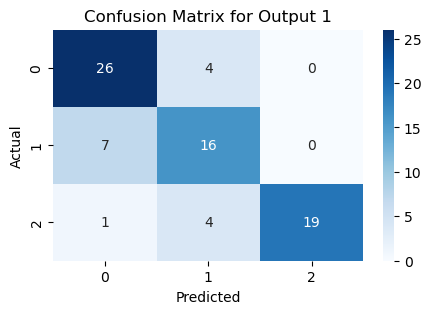

Accuracy for Output 2: 0.8311688311688312
Classification Report for Output 2:
              precision    recall  f1-score   support

           0       0.78      0.92      0.85        39
           1       0.90      0.74      0.81        38

    accuracy                           0.83        77
   macro avg       0.84      0.83      0.83        77
weighted avg       0.84      0.83      0.83        77



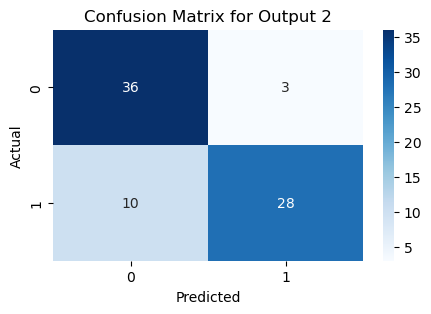

Hamming Loss: 0.18831168831168832
Subset Accuracy: 0.6363636363636364


In [13]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Assuming the model has been trained and test data (X_test, y1_test, y2_test) is available

# Predict on the test data
y_pred_test = model.predict(X_test)
y_pred_test_1 = np.argmax(y_pred_test[0], axis=1)
y_pred_test_2 = np.argmax(y_pred_test[1], axis=1)

# Convert true labels to integer representation if necessary
y1_test_int = np.argmax(y1_test, axis=1)
y2_test_int = np.argmax(y2_test, axis=1)

# Evaluate each output individually
for i, (true_labels, pred_labels, output_name) in enumerate([(y1_test_int, y_pred_test_1, 'Output 1'), (y2_test_int, y_pred_test_2, 'Output 2')]):
    accuracy = accuracy_score(true_labels, pred_labels)
    print(f"Accuracy for {output_name}: {accuracy}")
    print(f"Classification Report for {output_name}:\n{classification_report(true_labels, pred_labels)}")
    cm = confusion_matrix(true_labels, pred_labels)
    plt.figure(figsize=(5, 3))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix for {output_name}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

# Combine true and predicted labels for Hamming loss and subset accuracy calculation
y_test_combined = np.hstack((y1_test_int.reshape(-1, 1), y2_test_int.reshape(-1, 1)))
y_pred_test_combined = np.hstack((y_pred_test_1.reshape(-1, 1), y_pred_test_2.reshape(-1, 1)))

# Calculate Hamming loss manually
def calculate_hamming_loss(y_true, y_pred):
    return np.sum(y_true != y_pred) / np.size(y_true)

hamming = calculate_hamming_loss(y_test_combined, y_pred_test_combined)
print(f"Hamming Loss: {hamming}")

# Calculate subset accuracy
subset_accuracy = np.mean(np.all(y_test_combined == y_pred_test_combined, axis=1))
print(f"Subset Accuracy: {subset_accuracy}")

Best number of features: 13
Selected features: [0, 3, 5, 6, 7, 8, 9, 12, 13, 15, 16, 17, 18]


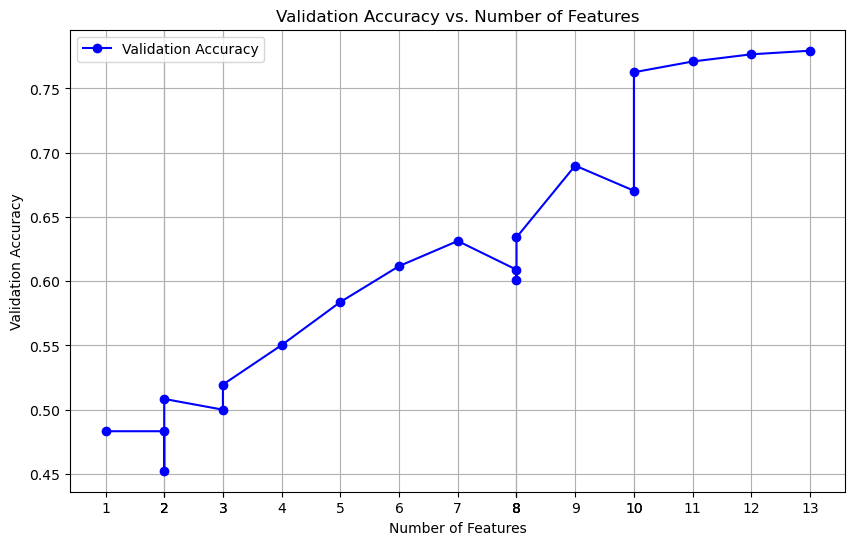

In [14]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l1_l2
from tensorflow.keras.losses import CategoricalCrossentropy
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import hamming_loss

# Define the model parameters
epochs = 300
activation = 'sigmoid'
dropout_rate = 0
l1 = 0
l2 = 0
learning_rate = 0.001
neurons = [32, 32]
num_hidden_layers = 2
cv_folds = 5
random_state = 42  # Ensure random_state is defined

# Create the model using the Functional API
def create_model(input_shape):
    inputs = Input(shape=(input_shape,))
    x = Dense(neurons[0], activation=activation, kernel_regularizer=l1_l2(l1=l1, l2=l2))(inputs)
    x = Dropout(dropout_rate)(x)
    for _ in range(1, num_hidden_layers):
        x = Dense(neurons[1], activation=activation, kernel_regularizer=l1_l2(l1=l1, l2=l2))(x)
        x = Dropout(dropout_rate)(x)
    output_1 = Dense(3, activation='softmax', name='output_1')(x)
    output_2 = Dense(2, activation='softmax', name='output_2')(x)
    model = Model(inputs=inputs, outputs=[output_1, output_2])
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(loss={'output_1': 'categorical_crossentropy', 'output_2': 'categorical_crossentropy'},
                  optimizer=optimizer, 
                  metrics={'output_1': 'accuracy', 'output_2': 'accuracy'})
    return model


# Variables to store performance metrics
feature_counts = []
subset_accuracies = []
hamming_losses = []

# Manual feature selection routine
best_accuracy = 0
best_features = []
num_features = X_train.shape[1]

for i in range(num_features):
    current_features = best_features + [i]
    model = create_model(len(current_features))

    # Fit model on the selected features
    history = model.fit(X_train[:, current_features], [y1_train, y2_train], 
                        validation_data=(X_train[:, current_features], [y1_train, y2_train]),
                        epochs=epochs, batch_size=32, verbose=0)
    
    # Evaluate the model
    val_accuracy_1 = history.history['val_output_1_accuracy'][-1]
    val_accuracy_2 = history.history['val_output_2_accuracy'][-1]
    avg_val_accuracy = (val_accuracy_1 + val_accuracy_2) / 2
    
    # Store metrics
    feature_counts.append(len(current_features))
    subset_accuracies.append(avg_val_accuracy)
    
    if avg_val_accuracy > best_accuracy:
        best_accuracy = avg_val_accuracy
        best_features = current_features

# Output the best number of features and the selected features
print(f"Best number of features: {len(best_features)}")
print(f"Selected features: {best_features}")

# Plotting subset accuracies vs. number of features
plt.figure(figsize=(10, 6))
plt.plot(feature_counts, subset_accuracies, marker='o', label='Validation Accuracy', color='blue')
plt.xlabel('Number of Features')
plt.ylabel('Validation Accuracy')
plt.title('Validation Accuracy vs. Number of Features')
plt.grid(True)
plt.legend()
plt.xticks(feature_counts)  # Set x-ticks to full integer values
plt.show()


Best number of features: 10
Selected features: [0, 3, 6, 7, 8, 12, 13, 15, 17, 18]


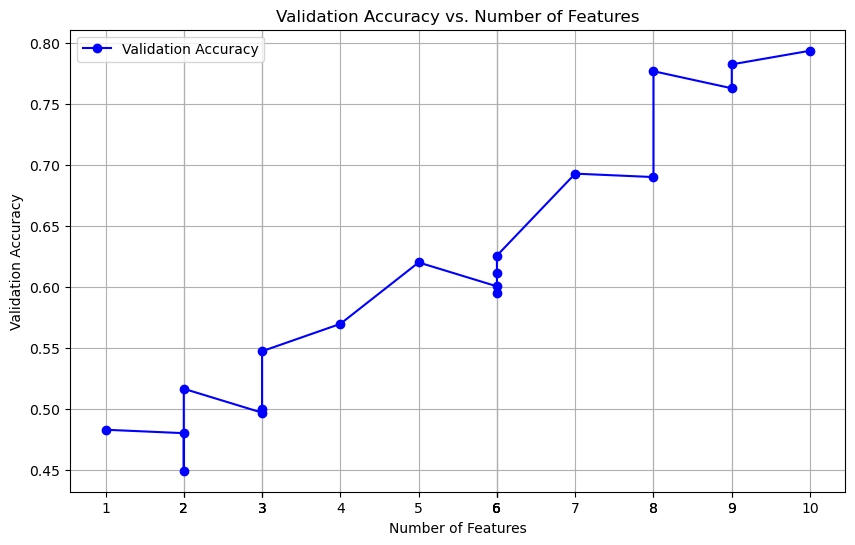

In [15]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l1_l2
from tensorflow.keras.losses import CategoricalCrossentropy
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import hamming_loss

# Define the model parameters
epochs = 300
activation = 'sigmoid'
dropout_rate = 0
l1 = 0
l2 = 0
learning_rate = 0.001
neurons = [32, 32]
num_hidden_layers = 2
cv_folds = 5
random_state = 42  # Ensure random_state is defined

# Create the model using the Functional API
def create_model(input_shape):
    inputs = Input(shape=(input_shape,))
    x = Dense(neurons[0], activation=activation, kernel_regularizer=l1_l2(l1=l1, l2=l2))(inputs)
    x = Dropout(dropout_rate)(x)
    for _ in range(1, num_hidden_layers):
        x = Dense(neurons[1], activation=activation, kernel_regularizer=l1_l2(l1=l1, l2=l2))(x)
        x = Dropout(dropout_rate)(x)
    output_1 = Dense(3, activation='softmax', name='output_1')(x)
    output_2 = Dense(2, activation='softmax', name='output_2')(x)
    model = Model(inputs=inputs, outputs=[output_1, output_2])
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(loss={'output_1': 'categorical_crossentropy', 'output_2': 'categorical_crossentropy'},
                  optimizer=optimizer, 
                  metrics={'output_1': 'accuracy', 'output_2': 'accuracy'})
    return model


# Variables to store performance metrics
feature_counts = []
subset_accuracies = []
hamming_losses = []

# Manual feature selection routine
best_accuracy = 0
best_features = []
num_features = X_train.shape[1]

for i in range(num_features):
    current_features = best_features + [i]
    model = create_model(len(current_features))

    # Fit model on the selected features
    history = model.fit(X_train[:, current_features], [y1_train, y2_train], 
                        validation_data=(X_train[:, current_features], [y1_train, y2_train]),
                        epochs=epochs, batch_size=32, verbose=0)
    
    # Evaluate the model
    val_accuracy_1 = history.history['val_output_1_accuracy'][-1]
    val_accuracy_2 = history.history['val_output_2_accuracy'][-1]
    avg_val_accuracy = (val_accuracy_1 + val_accuracy_2) / 2
    
    # Store metrics
    feature_counts.append(len(current_features))
    subset_accuracies.append(avg_val_accuracy)
    
    if avg_val_accuracy > best_accuracy:
        best_accuracy = avg_val_accuracy
        best_features = current_features

# Output the best number of features and the selected features
print(f"Best number of features: {len(best_features)}")
print(f"Selected features: {best_features}")

# Plotting subset accuracies vs. number of features
plt.figure(figsize=(10, 6))
plt.plot(feature_counts, subset_accuracies, marker='o', label='Validation Accuracy', color='blue')
plt.xlabel('Number of Features')
plt.ylabel('Validation Accuracy')
plt.title('Validation Accuracy vs. Number of Features')
plt.grid(True)
plt.legend()
plt.xticks(feature_counts)  # Set x-ticks to full integer values
plt.show()
